In [3]:
import numpy as np
import os 

from sklearn.linear_model import SGDClassifier
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

In [4]:
def get_data(): 
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    data = mnist['data']
    labels = mnist['target']
    return data, labels

In [5]:
data, labels = get_data()

In [6]:
def split_data(data, labes): 
    X_train = data[60000:]
    Y_train = labels[60000:]
    X_test = data[:60000]
    Y_test = labels[:60000]
    
    random_index = np.random.permutation(60000)
    X_train, Y_train = data[random_index], labels[random_index]
    data_dict = {'X_train':X_train, 'Y_train':Y_train, 'X_test':X_test, 'Y_test':Y_test}
    return data_dict

In [7]:
data_dict = split_data(data, labels)
data_dict.keys()

['X_test', 'X_train', 'Y_train', 'Y_test']

In [146]:
SDG = SGDClassifier(random_state=14)
SDG.fit(data_dict['X_train'], data_dict['Y_train'])

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=14, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

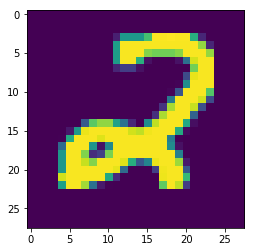

In [9]:
some_image = (data_dict['X_train'])[25]
image = some_image.reshape(28,28)
plt.imshow(image)

In [10]:
SDG.predict([some_image])

array(['2'], dtype='|S1')

In [149]:
from sklearn.externals import joblib
joblib.dump(SDG, 'models/SDG_image_classifier.pkl')

['models/SDG_image_classifier.pkl']

# Model Evaluation

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
print (data_dict['Y_train'])[7]

1


In [13]:
skfolds = StratifiedKFold(n_splits=3, random_state=19)
for train_index, test_index in skfolds.split(data_dict['X_train'], data_dict['Y_train']):
    clone_SDG = clone(SDG)
    x_train_folds = (data_dict['X_train'])[train_index]
    y_train_folds = (data_dict['Y_train'])[train_index]
    x_test_folds = (data_dict['X_train'])[test_index]
    y_test_folds = (data_dict['Y_train'])[test_index]
    
    clone_SDG.fit(x_train_folds, y_train_folds)
    y_pred = clone_SDG.predict(x_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print n_correct/float(len(y_pred))

0.8727754449110178
0.8571928596429822
0.8658298744811722


## Confusion Matrix

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(SDG, data_dict['X_train'], data_dict['Y_train'], cv=3)

In [15]:
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(data_dict['Y_train'], y_train_pred)

In [16]:
import pandas as pd
pd.DataFrame(con_mat)

,0,1,2,3,4,5,6,7,8,9
0,5759,2,21,11,19,29,41,5,27,9
1,9,6308,61,12,17,57,6,16,237,19
2,91,59,5226,80,126,44,70,73,152,37
3,81,26,317,4866,30,381,18,69,208,135
4,18,22,31,8,5408,16,39,12,55,233
5,100,19,37,170,144,4527,78,23,199,124
6,85,8,112,4,116,160,5361,8,56,8
7,35,27,85,28,137,12,5,5518,41,377
8,93,193,159,197,231,632,59,32,3975,280
9,52,27,11,74,435,58,1,211,112,4968


This confusion matrix shows that 0 is wrongly classified as 2 44 times, as 3, 8 times ect.

True Positive: correctly predicted that the var was the target value
True Negative: correctly predicted that the var was not the target value
False Positive: incorrectly predicted that the var was the target value 
False Negative: incorrectly predicted that the var was not the target value.

***Precision:***
* TP/TP + FP the accuracy of the positive predictions


***Recall:***

* TP/TP+FN also known as sensitivity or true positive rate. The ratio of positive instances that are correctly detected by the classifier

In [17]:
from sklearn.metrics import precision_score, recall_score
y_train_pred.shape

(60000,)

In [18]:
data_dict['Y_train'].shape

(60000,)

In [19]:
precision_score(data_dict['Y_train'], y_train_pred, average='macro')

0.8642411271952231

In [20]:
recall_score(data_dict['Y_train'], y_train_pred, average='macro')

0.86406622847375

This means that when the model predicts a value. it is correct 86.5% of the time. 
the recall score means it correctly indetifies 86.2% of the values. Not bad.  
<br/>
The f1 score combines both these metrics. It is the harmonic mean of precision and recall. The metric gives a much larger weight to lower values and therefore the score will only be high if both the precision and recall are high. 

In [21]:
from sklearn.metrics import f1_score 
f1_score(data_dict['Y_train'], y_train_pred, average='macro')

0.8627187686249581

f1 score is high when the recall and precision are equal. This however may not always be what you want.
<br/>  
A trade of must be made between precision and recall. If you alter the prediction threshold one will be increased while the other decreasees. You may want to alter this threshold as for example suppose you trained a model to predict videos that were safe for children to watch. You would want the precision to be very high but be too concerened the the recall was low. As the reprocussions would would not be as bad if a few suitible videos were flagged as long as all the unsuitible videos were discarded. 
<br/>  
The SGDClassier does not allow you to directly set thresholds but does give access to the function that provides the output on which the classifications are made. 

In [28]:
SGD = joblib.load('SDG_image_classifier.pkl')
y_scores = SGD.decision_function([some_image])
y_scores

array([[-1033563.47512945,  -996136.36086257,    91192.60460597,
         -649353.83691534,  -755846.49577662,  -728044.32520596,
         -657132.37652574, -1599518.14161135,  -835063.21271352,
        -1767141.56947691]])

In [66]:
threshold = 2000
ar = np.linspace(0, 9, num=10)
choice = (y_scores>threshold)[0]
ar[choice]

array([2.])

## Binary Classifier and the precision recall curve

In [69]:
bin_clas = SGDClassifier(random_state=19)

In [86]:
bin_target = (data_dict['Y_train']=='5')
bin_clas.fit(data_dict['X_train'], bin_target)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=19, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [105]:
some_im = data_dict['X_train'][1]
bin_clas.predict([some_im]) #image not predicted to be 5

array([False])

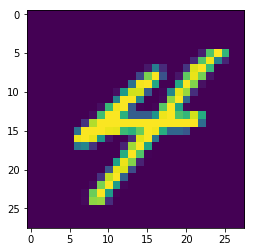

In [104]:
plt.imshow(some_im.reshape(28,28))

In [108]:
y_scores = bin_clas.decision_function([some_im])
y_scores

array([-78198.90155919])

In [127]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(bin_clas, data_dict['X_train'], bin_target, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(bin_target, y_scores)

In [130]:
def plt_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="recall")
    plt.xlabel("Threshold")
    plt.ylim(0,1)
    plt.legend()


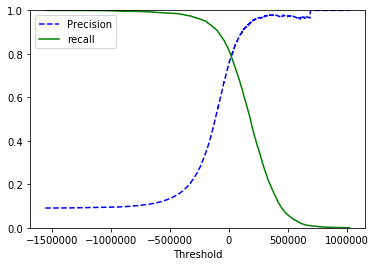

In [131]:
plt_precision_recall(precisions, recalls, thresholds)

In [150]:
joblib.dump(bin_clas, "models/num5classifier.pkl")

['models/num5classifier.pkl']

## ROC curve
The receiver operating curve plots the True positive rate against the False Positive rate

In [134]:
from sklearn.metrics import roc_curve
TPR, FPR, thresholds = roc_curve(bin_target, y_scores)

In [143]:
def plt_roc_curve(FPR, TPR, label=None): 
    plt.plot(FPR, TPR, label=label)
    plt.plot([0,1], [0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False positive rate")
    plt.ylabel("True Positive rate")

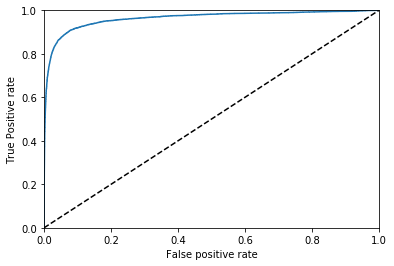

In [144]:
plt_roc_curve(TPR, FPR)

As you can see the higher the TPR the more false positives you will get. The best models will stay as far away from the dotted line as possible. A way to measure the performance of these models is to measure the arear under the graph. The higher it is the better the model is.

In [148]:
from sklearn.metrics import roc_auc_score
roc_auc_score(bin_target, y_scores)

0.9635421961911675

### Lets train a RandomForestClassifier and comapare to the SGDClassifier

In [158]:
from sklearn.ensemble import RandomForestClassifier
ran_forest = RandomForestClassifier(random_state=42)
y_proba_forest = cross_val_predict(ran_forest, data_dict['X_train'], bin_target, cv=3, method="predict_proba")


In [163]:
y_scores_forest = y_proba_forest[:,1]
pd.DataFrame(y_proba_forest).head() #the table has a row per instance and a columns per prediction e.g.
# the first row is the prediction of a single instance. There is 0% chance it is a 5 and 100% it is not.

,0,1
0,1.0,0.0
1,0.9,0.1
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


In [165]:
y_scores_forest = y_proba_forest[:,1] #the second column probablity that the value is a 5

In [170]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(bin_target, y_scores_forest)

In [188]:
def plt_two_roc_curve(FPR, TPR, FPR2, TPR2, label=None, label2=None): 
    plt.plot(FPR, TPR, label=label)
    plt.plot(FPR2, TPR2, "g--", label=label2)
    plt.plot([0,1], [0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False positive rate")
    plt.ylabel("True Positive rate")
    plt.show()

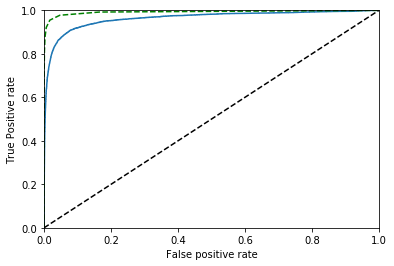

In [189]:
plt_two_roc_curve(TPR, FPR, fpr_forest, tpr_forest, label="SGDC", label2="RandomForest")

As you can see the ensemble algorithm is much more effective. lets check its AUC score

In [190]:
roc_auc_score(bin_target, y_scores_forest)

0.992351906584276

***99 wow that's pretty good lets save this one.***

In [193]:
joblib.dump(ran_forest, "models/forest_num5classifier.pkl")

['models/forest_num5classifier.pkl']

In [195]:
y_train_pred = cross_val_predict(ran_forest, data_dict['X_train'], bin_target, cv=3)
precision_score(bin_target, y_train_pred)

0.9872111285618129

In [196]:
recall_score(bin_target, y_train_pred)

0.8116583656152001